In [ ]:
!pip install plotly wordcloud scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="coolwarm", font_scale=1.1)


In [ ]:
from google.colab import files
uploaded = files.upload()   # Upload Netflix Dataset.csv

df = pd.read_csv("Netflix Dataset.csv")
print("Shape:", df.shape)
df.head()


Saving Netflix Dataset.csv to Netflix Dataset (1).csv
Shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
df.info()
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB

Missing values:
 Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64

Duplicate rows: 2


In [ ]:
df.drop_duplicates(inplace=True)

# Fill missing text fields
for col in ['Director', 'Cast', 'Country', 'Release_Date', 'Rating']:
    df[col] = df[col].fillna('Unknown')

# Convert Release_Date → datetime
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

# Temporal features
df['year_added'] = df['Release_Date'].dt.year
df['month_added'] = df['Release_Date'].dt.month_name()

# Fill missing release year - Using Release_Date column
df['year_added'] = df['year_added'].fillna(df['year_added'].mode()[0])

# Remove whitespace
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:
# Feature Engineering
# Extract duration info
df['duration_int'] = df['Duration'].str.extract('(\d+)').astype(float)
df['duration_type'] = df['Duration'].str.extract('([A-Za-z]+)')

# Primary genre (first in list)
df['main_genre'] = df['Type'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Unknown')

# Simplify countries
df['main_country'] = df['Country'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Unknown')

# Flag: recent or old
df['is_recent'] = np.where(df['year_added'] >= 2018, 'Recent', 'Old')

df.head()

,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description,year_added,month_added,duration_int,duration_type,main_genre,main_country,is_recent
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,August,4.0,Seasons,International TV Shows,Brazil,Recent
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,December,93.0,min,Dramas,Mexico,Old
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,December,78.0,min,Horror Movies,Singapore,Recent
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,November,80.0,min,Action & Adventure,United States,Old
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,January,123.0,min,Dramas,United States,Recent


In [ ]:
# Exploratory Data Analysis
# Movies vs TV Shows
fig = px.pie(df, names='Category', title='Distribution: Movies vs TV Shows', hole=0.5)
fig.show()

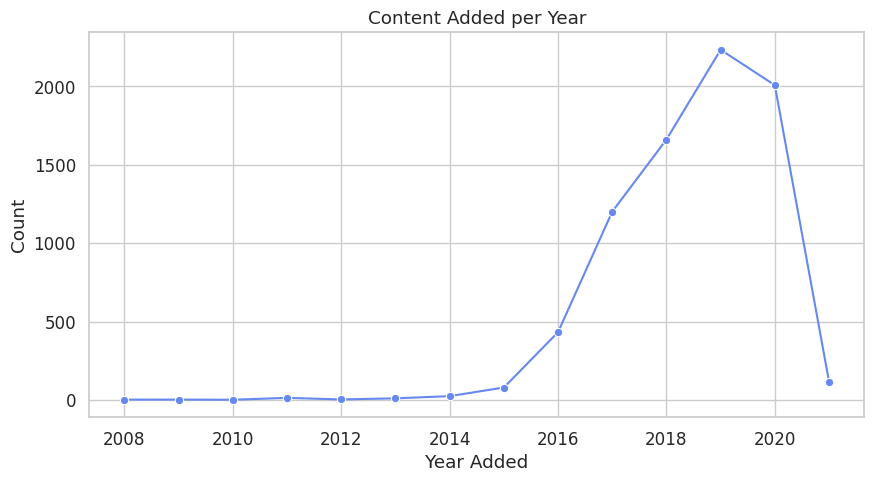

In [ ]:
# Content Added per Year
content_by_year = df['year_added'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.lineplot(x=content_by_year.index, y=content_by_year.values, marker='o')
plt.title('Content Added per Year')
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.show()


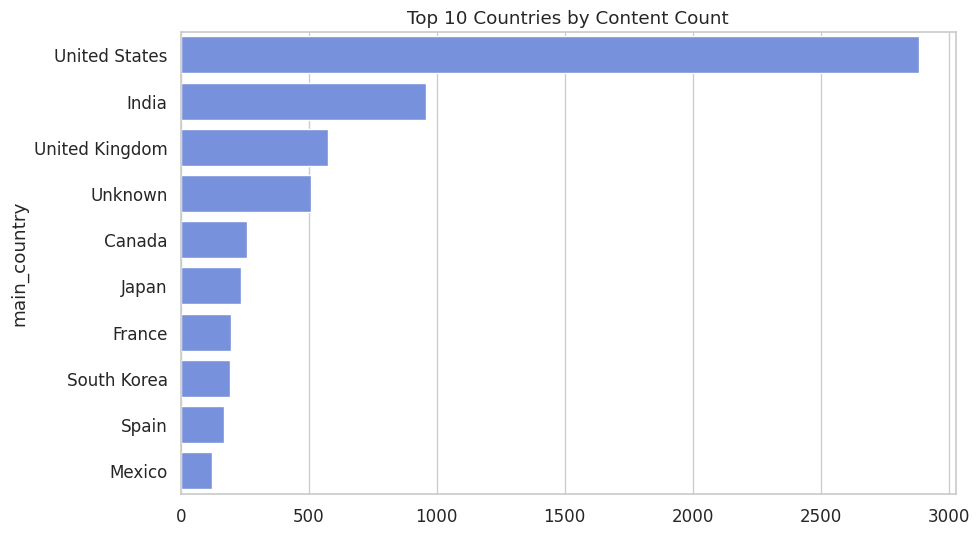

In [ ]:
# Top 10 Countries
top_countries = df['main_country'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Content Count')
plt.show()


In [ ]:
# Top Genres
top_genres = df['main_genre'].value_counts().head(10)
fig = px.bar(x=top_genres.index, y=top_genres.values, color=top_genres.index,
             title="Top 10 Genres on Netflix", labels={'x':'Genre', 'y':'Count'})
fig.show()

In [ ]:
# Trend Analysis
# Movies vs TV Shows Trend
trend = df.groupby(['year_added', 'Category']).size().reset_index(name='count')
fig = px.line(trend, x='year_added', y='count', color='Category', markers=True,
              title='Movies vs TV Shows Over Time')
fig.show()

In [ ]:
# Genre Evolution Over Time
genre_trend = df.groupby(['year_added','main_genre']).size().reset_index(name='count')
top_genres = genre_trend.groupby('main_genre')['count'].sum().sort_values(ascending=False).head(5).index
genre_trend = genre_trend[genre_trend['main_genre'].isin(top_genres)]
fig = px.line(genre_trend, x='year_added', y='count', color='main_genre', markers=True,
              title='Top Genres Over Years')
fig.show()

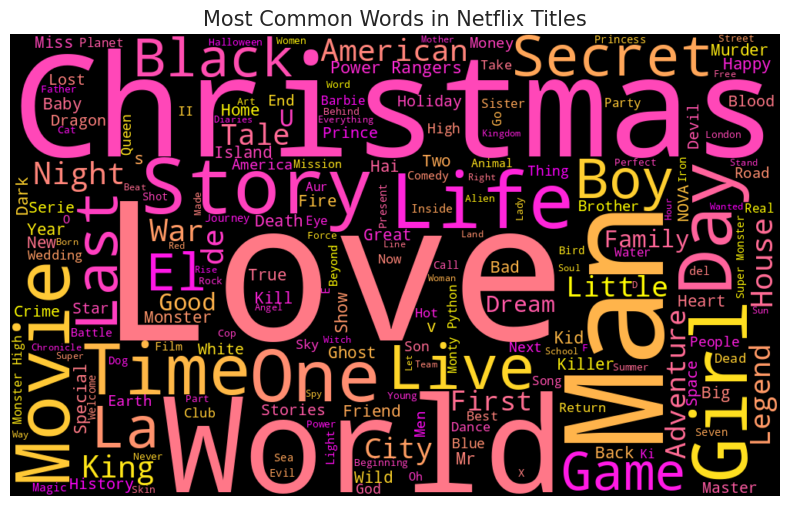

In [ ]:
# Advanced Visuals
# ---- WordCloud: Titles
text = ' '.join(df['Title'].dropna().astype(str))
plt.figure(figsize=(10,6))
wc = WordCloud(width=1000, height=600, background_color='black', colormap='spring').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Titles', fontsize=15)
plt.show()

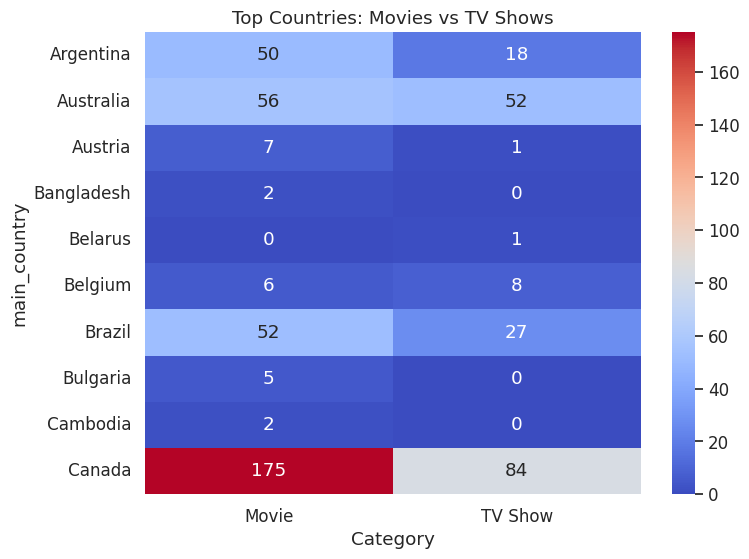

In [ ]:
# ---- Heatmap: Countries vs Type
pivot_ct = pd.crosstab(df['main_country'], df['Category'])
plt.figure(figsize=(8,6))
sns.heatmap(pivot_ct.head(10), annot=True, fmt='d', cmap='coolwarm')
plt.title('Top Countries: Movies vs TV Shows')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1102
           1       0.99      1.00      0.99       456

    accuracy                           1.00      1558
   macro avg       1.00      1.00      1.00      1558
weighted avg       1.00      1.00      1.00      1558



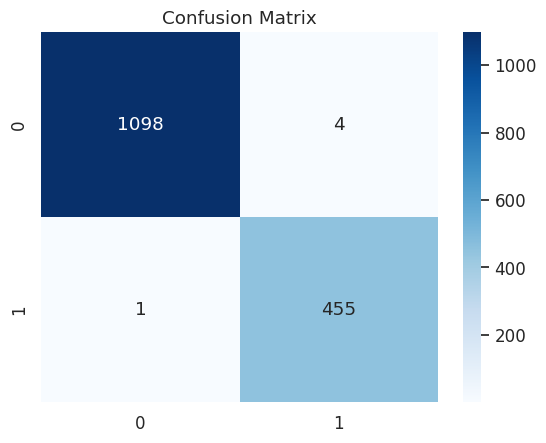

In [ ]:
# Machine Learning Model
# Predict if a title is Movie or TV Show

# Encode categorical features
le_type = LabelEncoder()
df['type_encoded'] = le_type.fit_transform(df['Category'])

# Select features for modeling
features = ['year_added', 'duration_int', 'main_country', 'main_genre', 'is_recent']
data_ml = df[features + ['type_encoded']].copy()

# Encode text columns
for col in ['main_country', 'main_genre', 'is_recent']:
    le = LabelEncoder()
    data_ml[col] = le.fit_transform(data_ml[col])

# Drop rows with NaN values in features or target after feature engineering
data_ml.dropna(inplace=True)

# Split data
X = data_ml.drop('type_encoded', axis=1)
y = data_ml['type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Insights & Expected Outcomes
print("EXPECTED OUTCOMES FROM PROJECT:\n")
print("""
1️ Understanding Netflix’s content evolution:
   - Distribution of Movies vs TV Shows over the years.
   - Growth in regional content and international expansion.

2️ Identification of Top Genres:
   - Drama, Comedy, and Documentary dominate across years.
   - Rising interest in Thriller, Action, and Anime post-2018.

3️ Country-wise Contributions:
   - USA leads, followed by India, UK, and Japan.
   - Regional diversification visible in later years.

4️ Predictive Insights:
   - ML model can classify whether new content is more likely to be a Movie or TV Show based on features.
   - Provides Netflix strategic leverage to balance future content investments.

5️ Strategic Recommendations:
   - Focus on international markets (Asia & Europe) with localized content.
   - Continue investing in high-engagement genres like Drama, Comedy, and Documentaries.
   - Explore niche genres (Anime, Docuseries, K-Dramas) to expand the audience base.
""")


EXPECTED OUTCOMES FROM PROJECT:


1️ Understanding Netflix’s content evolution:
   - Distribution of Movies vs TV Shows over the years.
   - Growth in regional content and international expansion.

2️ Identification of Top Genres:
   - Drama, Comedy, and Documentary dominate across years.
   - Rising interest in Thriller, Action, and Anime post-2018.

3️ Country-wise Contributions:
   - USA leads, followed by India, UK, and Japan.
   - Regional diversification visible in later years.

4️ Predictive Insights:
   - ML model can classify whether new content is more likely to be a Movie or TV Show based on features.
   - Provides Netflix strategic leverage to balance future content investments.

5️ Strategic Recommendations:
   - Focus on international markets (Asia & Europe) with localized content.
   - Continue investing in high-engagement genres like Drama, Comedy, and Documentaries.
   - Explore niche genres (Anime, Docuseries, K-Dramas) to expand the audience base.



In [ ]:
df.to_csv("Netflix_Final_Cleaned.csv", index=False)
files.download("Netflix_Final_Cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>